In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 8
refRatio = 2
c = 1.
CFL = 0.5
nt = 32
RK = 4
deriv = 'CD'

In [3]:
if (RK == 1):
    TimeIntegratorFunc = ST.ForwardEuler
else:
    if (RK == 2):
        TimeIntegratorFunc = ST.MidpointMeth
    else:
        TimeIntegratorFunc = ST.RK4

if (deriv == 'U'):
    DiffMatFunc = OT.Upwind1D
    DiffFunc = ST.Upwind
else:
    DiffMatFunc = OT.CenterDiff1D
    DiffFunc = ST.CenterDiff

In [4]:
omega = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)
degFreed = omega.degFreed
nh_min = omega.nh_min
nh_max = omega.nh_max
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
derivMat = DiffMatFunc(omega)
spatOp = -c * derivMat
strings = omega.strings
timePropOp = LA2.expm(t * spatOp)
waves = WT.MakeWaves(omega)
omegaF = BT.Grid(nh_max)
wavesF = WT.MakeWaves(omegaF)
# print(strings)

[[ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.         -0.5        -0.5       ]
 [-1.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.         -1.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.          0.5         0.5         0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.66666667 -0.33333333  1.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.          0.          1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.          0.          1.          0.          0.     

In [5]:
print('derivMat =\n', derivMat, '\n')
print('spatOp =\n', spatOp, '\n')
print('timePropOp =\n', timePropOp, '\n')

derivMat =
 [[ 0.          4.          0.          0.          0.          0.          0.          0.          0.          0.         -2.         -2.        ]
 [-4.          0.          4.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.         -4.          0.          4.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         -4.          0.          2.          2.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -5.33333333 -2.66666667  8.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -8.          0.          8.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -8.          0.          8.          0.     

In [6]:
restrictOp = GTT.CoarsenOp(omega)

nullspace = OT.FindNullspace(omega, waves)

x = np.linspace(0, 1, num = nh_max + 1)[:-1] + (1. / (2. * nh_max))
sqStart = int(nh_max / 8)
sqEnd = int((2 * nh_max) / 8)
print(sqStart, sqEnd)

2 4


In [7]:
    # waveform = np.zeros(nh_max, float)
    # waveform[sqStart:sqEnd] = 1
    # waveform = x - 0.5

    # FCoefs = nullspace[:, ::-1][:, 0]
    # waveform = wavesF @ FCoefs
FCoefsF = np.eye((nh_max, nh_max), float)[:, :nh_min]
FCoefs = np.zeros((nh_max, nh_max), float)[:, :nh_min]
PropFCoefs = np.zeros((nh_max, nh_max), float)[:, :nh_min]
solverCoefs = np.zeros((nh_max, nh_max), float)[:, :nh_min]
exTimeCoefs = np.zeros((nh_max, nh_max), float)[:, :nh_min]
labels = [[] for k in range(nh_min)]
xProp = r'$(x - c t)$'
for k in range(nh_min):

    waveformF = wavesF @ nullspace @ FCoefsF[:, k]

    # FCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)
    # # # FCoefs[1::2] = 0
    # waveform = waves @ nullspace @ FCoefs
    propFCoefs[:, k] = FFTT.PropRestrictWaves(omega, waveformF, c, t)
    waveform = restrictOp @ waveformF
    FCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

    solverCoefs[:, k] = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
    exTimeForm = timePropOp @ waveform
    exTimeCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)


    # propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
    labels[k] = [r'$u_{0} (x)$', r'Exact $u_{0} (x - c t)$', r'Exact Time $u_{0} (x - c t)$', r'Time Integrator $u_{0} (x - c t)$']
    allCoefs = PT.Load(FCoefs[:, k], propFCoefs, exTimeCoefs, solverCoefs)


IndentationError: expected an indented block (<ipython-input-7-e48e580189e2>, line 16)

In [8]:
restrictOp = GTT.CoarsenOp(omega)

nullspace = OT.FindNullspace(omega, waves)

x = np.linspace(0, 1, num = nh_max + 1)[:-1] + (1. / (2. * nh_max))
sqStart = int(nh_max / 8)
sqEnd = int((2 * nh_max) / 8)
print(sqStart, sqEnd)
waveform = np.zeros(nh_max, float)
waveform[sqStart:sqEnd] = 1
waveform = 0.5 * x**2 - (0.5 * x) #x - 0.5
# FCoefs = nullspace[:, ::-1][:, 0]
# waveform = wavesF @ FCoefs


print(x)
print(waveform)

# FCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)
# # # FCoefs[1::2] = 0
# waveform = waves @ nullspace @ FCoefs
propFCoefs = FFTT.PropRestrictWaves(omega, waveform, c, t)
waveform = restrictOp @ waveform
FCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

solverCoefs = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
exTimeForm = timePropOp @ waveform
exTimeCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)
solverCoefs2 = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, TT.Upwind)


# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
labels = [r'$u_{0} (x)$', r'Exact $u_{0} (x - c t)$', r'Exact Time $u_{0} (x - c t)$', r'Time Integrator $u_{0} (x - c t)$']
allCoefs = PT.Load(FCoefs, propFCoefs, exTimeCoefs, solverCoefs)


2 4
[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
[-0.01513672 -0.04248047 -0.06591797 -0.08544922 -0.10107422 -0.11279297 -0.12060547 -0.12451172 -0.12451172 -0.12060547 -0.11279297 -0.10107422 -0.08544922 -0.06591797 -0.04248047 -0.01513672]

Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         

[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.12


[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0

[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.06

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.     

[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.12

[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125  0.125 ]

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.12

[1.33333333 1.         1.         1.         0.5        1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 ]

[ 0.          0.          0.          0.         -0.33333333  0.          0.          0.          0.          0.          0.         -0.33333333]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5        -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]



In [15]:
print(x)
print(waveform)
# print(derivMat)
print('')
print(derivMat @ waveform)
print('')

[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
[-0.02880859 -0.07568359 -0.10693359 -0.12255859 -0.12451172 -0.12060547 -0.11279297 -0.10107422 -0.08544922 -0.06591797 -0.04248047 -0.01513672]

[-0.1875     -0.3125     -0.1875     -0.0625      0.02083333  0.09375     0.15625     0.21875     0.28125     0.34375     0.40625     0.07291667]



Are you *sure* your labels are ordered correctly?


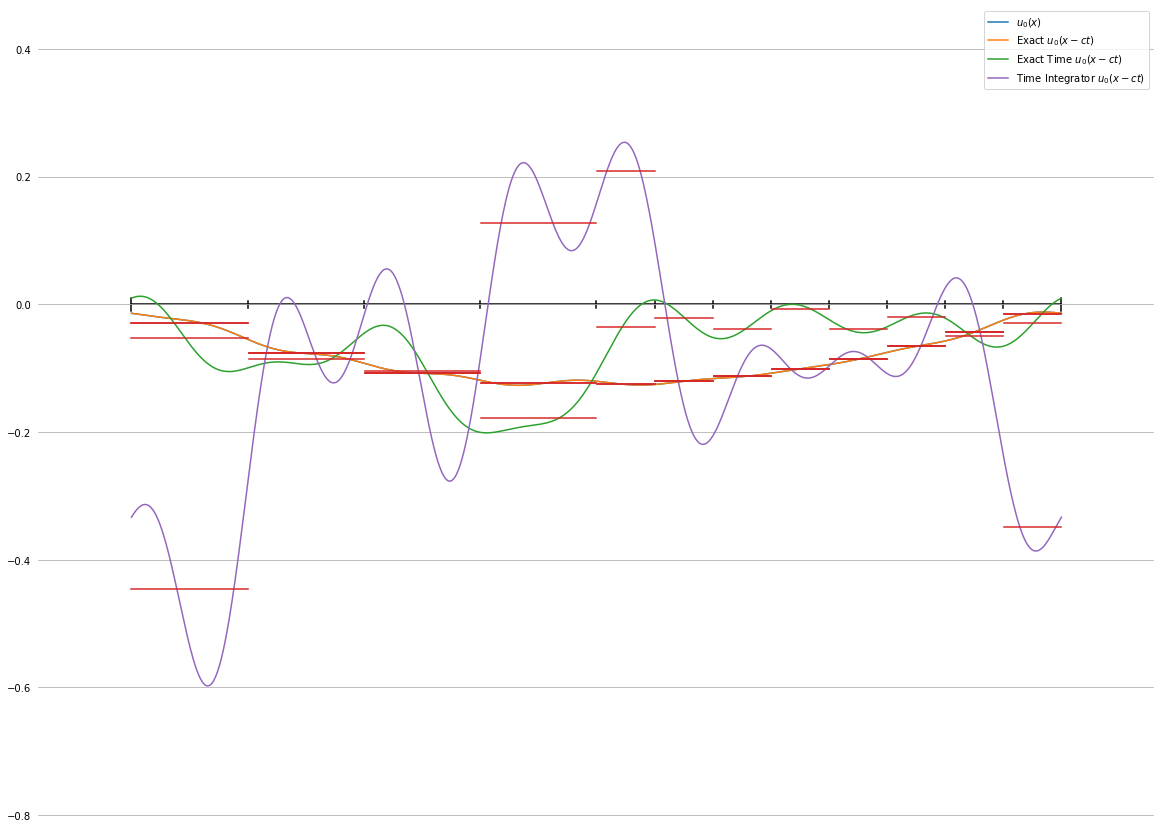

In [10]:
PT.PlotMixedWave(omega, waves, nullspace @ allCoefs, rescale = [4, 6], labels = labels, yGrid = True, dpi = 300)


This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/initial.


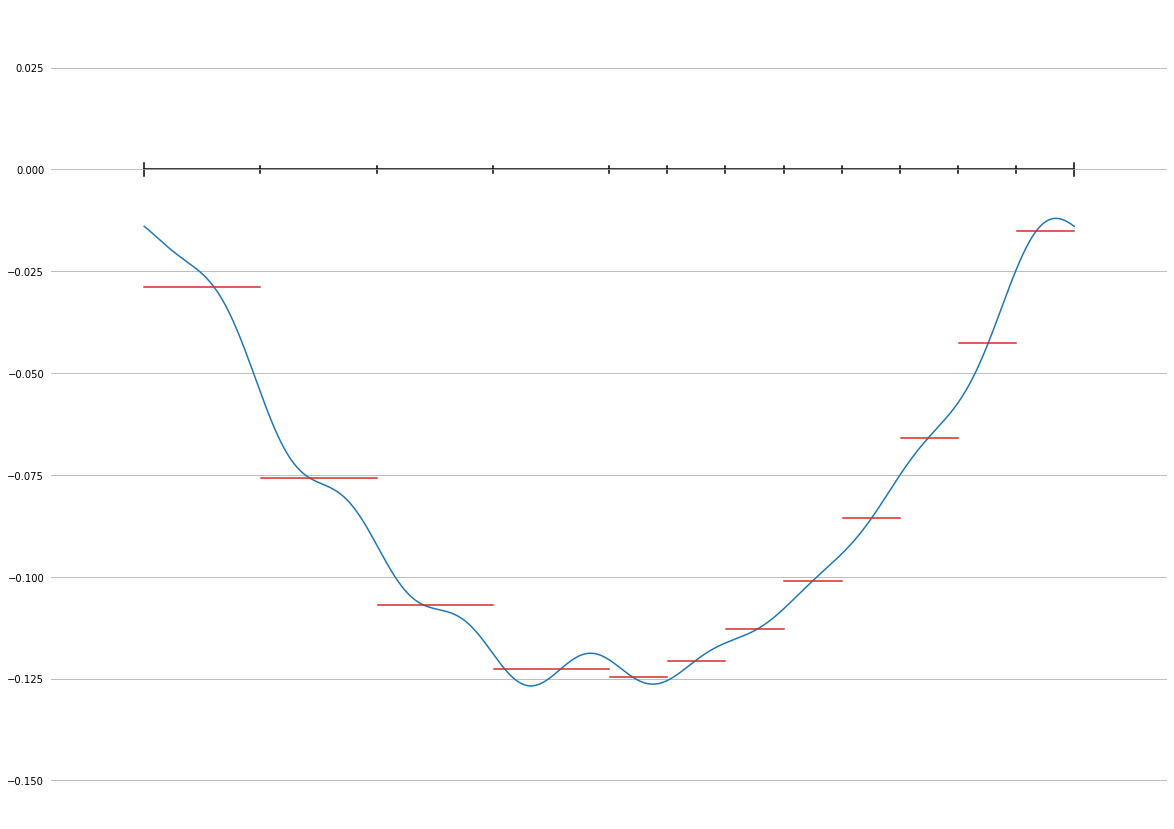

In [11]:
PT.PlotMixedWave(omega, waves, nullspace @ FCoefs, rescale = [4, 6], yGrid = True, dpi = 300, saveName = 'initial')


This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/final.


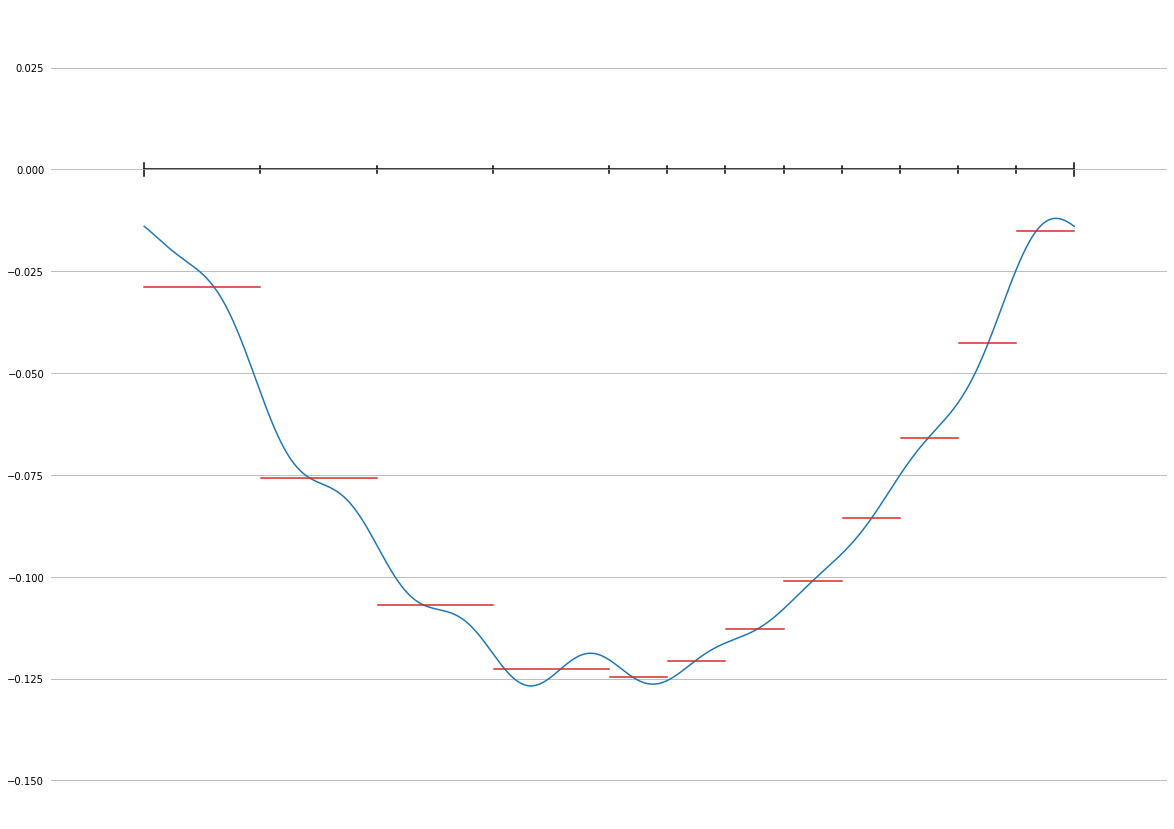

In [12]:
PT.PlotMixedWave(omega, waves, nullspace @ propFCoefs, rescale = [4, 6], yGrid = True, dpi = 300, saveName = 'final')


5
5
5
5
actual:
[2.53199103e-04 5.73542117e-03 2.54399958e-03 4.28368247e-03 5.06768723e-06 9.51608336e-04 9.93266697e-06]
+
[3.15637169e-02 3.67858324e-04 1.48954940e-02 1.03614319e-03 5.66910342e-05 1.45949392e-05 3.77461961e-03]
=
[3.18169160e-02 6.10327950e-03 1.74394935e-02 5.31982565e-03 6.17587214e-05 9.66203275e-04 3.78455228e-03]
sqrt
[0.17837297 0.07812349 0.13205867 0.07293713 0.00785867 0.03108381 0.06151871]
theoretical:
[4.67865864e-09 1.05257278e-07 4.21079277e-08 2.61373835e-36 1.16966466e-07 9.47315499e-07 2.29254273e-07]
+
[2.53001840e-03 1.55384022e-04 2.12429779e-05 1.07411420e-05 5.64352930e-08 3.36863422e-07 3.75759178e-06]
=
[2.53002308e-03 1.55489279e-04 2.12850858e-05 1.07411420e-05 1.73401759e-07 1.28417892e-06 3.98684605e-06]
sqrt
[0.05029933 0.01246953 0.00461358 0.00327737 0.00041642 0.00113322 0.00199671]

actual:
[2.31989962e-03 8.05425762e-04 1.07156407e-03 4.81175822e-04 3.71327409e-06 1.15059443e-04 7.27801721e-06]
+
[9.69342589e-04 1.09199356e-04 7.66

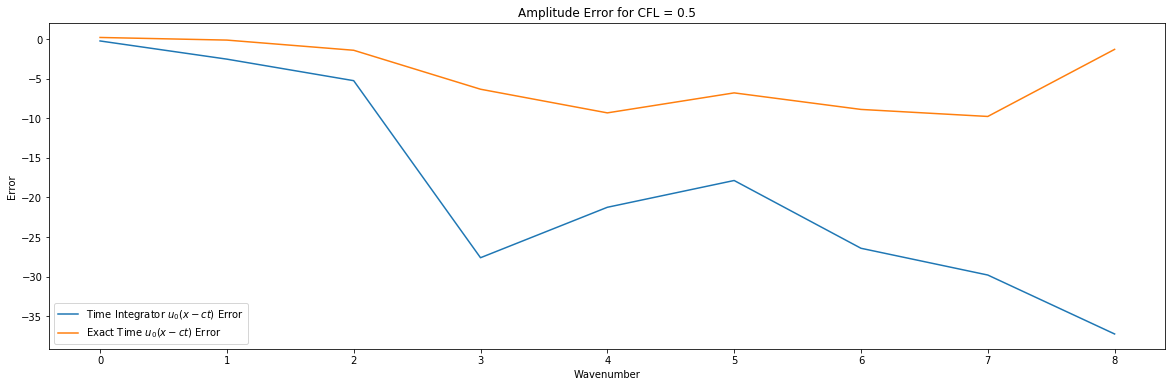

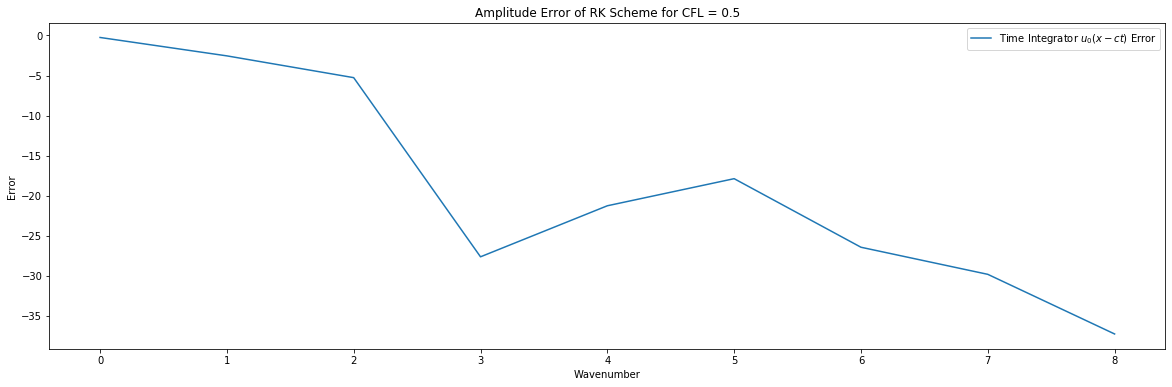

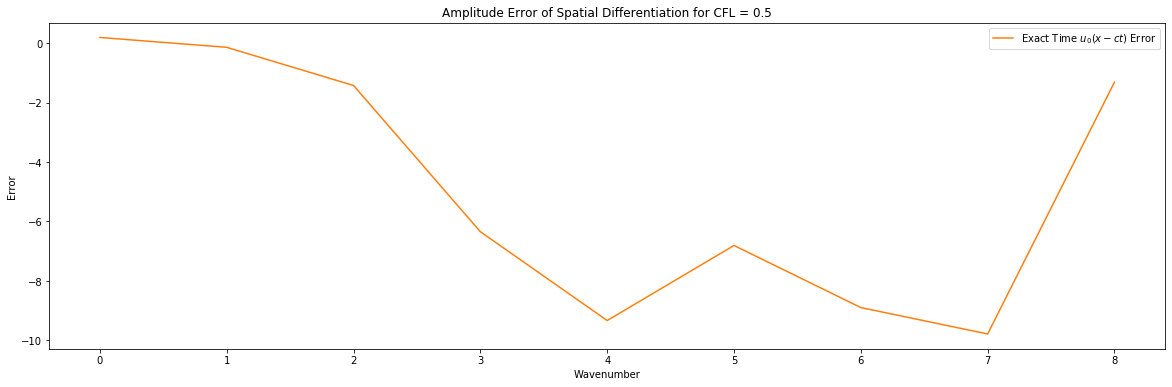

In [13]:
print(len(solverCoefs[1::2][:-1]))
print(len(solverCoefs[::2][1:]))
print(len(propFCoefs[1::2][:-1]))
print(len(propFCoefs[::2][1:]))
ampKs, solverError = TT.AmpError(omega, nullspace @ propFCoefs, nullspace @ solverCoefs)
ampKs, exTimeError = TT.AmpError(omega, nullspace @ propFCoefs, nullspace @ exTimeCoefs)
ks, error = TT.CalcError(omega, nullspace @ propFCoefs, nullspace @ solverCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, solverError, label = labels[3] + ' Error', color = PT.ColorDefault(0))
plt.plot(ampKs, exTimeError, label = labels[2] + ' Error', color = PT.ColorDefault(1))
plt.title('Amplitude Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, solverError, label = labels[3] + ' Error', color = PT.ColorDefault(0))
plt.title('Amplitude Error of RK Scheme for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, exTimeError, label = labels[2] + ' Error', color = PT.ColorDefault(1))
plt.title('Amplitude Error of Spatial Differentiation for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
print(GTT.MakeLinearInterp(8))

In [ ]:
# A is the main diagonal; C is the subdiagonal; G is the sub-subdiagonal; E is the superdiagonal; H is the super-superdiagonal.
n = omega.degFreed
hs = omega.h
A = hs - np.roll(hs, 1)
B = A + 0
F = np.roll(A, -1)
F[F > 0] = 1. / 3.
F[F != 1. / 3.] = 0
A[A < 0] = -1. / 3.
A[A != -1. / 3.] = 0
A = A - F
B[B > 0] = 0.5
B[B < 0] = 2. / 3.
C = -np.roll(B, -1)
B[B < 2. / 3.] = 1.
C[C == 0] = -1.
D = np.roll(C, -1)
D[D != -0.5] = 0
E = -C
E[E == 0.5] = 4. /3.
E[E == 2. / 3.] = 0.5
G = np.roll(C, -1)
G[G != -0.5] = 0
H = E + 0
H[H != 0.5] = 0
Deriv = np.zeros((n, n), float)
np.fill_diagonal(Deriv, A)
np.fill_diagonal(Deriv[1:], C)
np.fill_diagonal(Deriv[:, 1:], E)
np.fill_diagonal(Deriv[2:], G)
np.fill_diagonal(Deriv[:, 2:], H)
Deriv[0, n - 1] = C[::-1][0]
Deriv[0, n - 2] = G[::-1][1]
Deriv[1, n - 1] = G[::-1][0]

Deriv[n - 1, 0] = E[::-1][0]
Deriv[n - 2, 0] = H[::-1][1]
Deriv[n - 1, 1] = H[::-1][0]
hMat = OT.StepMatrix(omega)
# print(hMat)
# print('')
print(Deriv)

In [ ]:
# Put this in new notebook.
# Given, poly coefs c_0 through c_p, fit cell-ave values
# Given phi_c, phi_j, phi_j-1, as cell averages, what's the matrix that tells you the coefs given the cell averages

A = np.arange(12).reshape(3, 4)
print(A)
print('')
print(A[:2, :])